# 1. Packages

In [84]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skm
%matplotlib inline
#plt.rcParams['figure.figsize'] = [20, 6]

# 2. Data Import

## 2.1 Training Data

In [85]:
train_data = pd.read_csv('../train_sample_and_hold_NA_constant.csv')
#train_data = train_data[train_data.filename.isin(train_data.filename.unique()[0:1001])].set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)
train_data = train_data.set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)


## 2.2 Validation Data

In [86]:
val_data = pd.read_csv('../val_sample_and_hold_NA_constant.csv')
#val_data = val_data[val_data.filename.isin(val_data.filename.unique()[0:501])].set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)
val_data = val_data.set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)

# 3. Formatting Data for LSTM

## 3.1 Function to Convert Data for LSTM

convert series to supervised learning; modified by Andy, taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [87]:
#How many hours back do we want to evaluate the onset of sepsis? I am going to start with 5 hours, but this is another hyperparameter we could tune.
num_of_past_hours = 4

def series_to_supervised(data, n_in= num_of_past_hours, n_out=1, dropnan=True):
	values = data.values
	n_vars = 1 if type(values) is list else data.shape[1]
	df = pd.DataFrame(values)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [88]:
# oversampling septic 

### Oversampling 
from sklearn.utils import resample

# separate minority and majority classes
not_sepsis = train_data[train_data.SepsisLabel==0]
sepsis = train_data[train_data.SepsisLabel==1]

# upsample minority
sepsis_upsampled = resample(sepsis,
                          replace=True, # sample with replacement
                          n_samples=len(not_sepsis), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled_train = pd.concat([not_sepsis, sepsis_upsampled])

In [89]:
converted_train = upsampled_train.groupby('filename').apply(series_to_supervised)
converted_val = val_data.groupby('filename').apply(series_to_supervised)

## 3.2 Splitting Data into Input and Output Variables

In [90]:
train_X, train_y = converted_train.iloc[:, :-1].values, converted_train.iloc[:, -1].values
val_X, val_y = converted_val.iloc[:, :-1].values, converted_val.iloc[:, -1].values

## 3.3 Reshaping Data into 3D Input for LSTM

I found this link to helpful with explaining [samples, timesteps, features] when reshaping the data for the LSTM https://stats.stackexchange.com/questions/264546/difference-between-samples-time-steps-and-features-in-neural-network . Might be redundant for you guys, but I thought I'd include it anyways just in case.

In [91]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

In [92]:
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(1733552, 1, 174) (1733552,) (278775, 1, 174) (278775,)


# 4. Building the LSTM

As a proof of concept, I just made the model based on the example from: (https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) and continued to modify it slowly. 

Looking at the results, though, I am quite skeptical. It seems to be working _too_ well, which makes me think something is wrong somewhere. Just don't know what yet.

I found that changing the optimizer to RMS prop and adjusting some hyperparameters stopped the model from eventually always predicting 'no' so I am a little more comfortable with the results now (especially since the model seems to be predicting 'yes' accurately much more often). One thing I've noticed is that the model must either find some very obvious "no's" since I haven't seen anything other than 265685 actual-predicted 'no' (i.e. the top left of the confusion matrix), or again there is some weirdness going on. Please let me know what you guys think!

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                45000     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               6528      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)              

Text(0, 0.5, 'Loss')

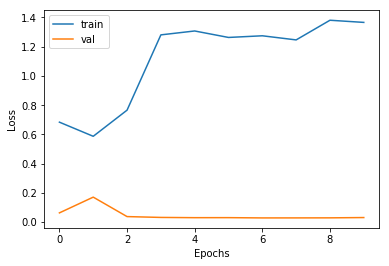

In [93]:
# Hyperparameters
lr = 0.001
epochs = 10
decay = 0.1
batch_size = 72
momentum= 0.0


#  Model Architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))

model.summary()

# Select and Tune Optimizer; I've included other potential ones below for quicker tuning. Some values are left as default as per recommendations from: https://keras.io/optimizers/

#optimizer= tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
#optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
optimizer= tf.keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)

# Compile Model
model.compile(optimizer= optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

# Fit network
history = model.fit(train_X, train_y, epochs= epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False, class_weight={0:1, 1:100})

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 5. Confusion Matrix Using Validation Data

In [94]:
yhat = model.predict(val_X)
confusion_matrix = tf.math.confusion_matrix(
    val_y,
    yhat,
)
confusion_matrix= pd.DataFrame(confusion_matrix.numpy())
confusion_matrix.rename(columns={0:'Predicted Sepsis: No', 1: 'Predicted Sepsis: Yes'}, 
                 index={0:'Actual Sepsis: No',1:'Actual Sepsis: Yes'}, 
                 inplace=True)
# Other metrics
PPV = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[0,1])
NPV = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[1,0] + confusion_matrix.iloc[1,1])

RR = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,0])
SR = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[0,1] + confusion_matrix.iloc[1,1])

In [95]:
print(confusion_matrix)
print(
    '\nPrecision/ Positive-Predictive Value (PPV): ' + str(PPV), 
    '\nNegative-Predictive Value (NPV): ' + str(NPV),
    '\nSensitivity/ Recall-Rate (RR): ' + str(RR),
    '\nSpecificity Rate (SR): ' + str(SR)
)

                    Predicted Sepsis: No  Predicted Sepsis: Yes
Actual Sepsis: No                 273614                      0
Actual Sepsis: Yes                   710                   4451

Precision/ Positive-Predictive Value (PPV): 1.0 
Negative-Predictive Value (NPV): 0.8624297616740941 
Sensitivity/ Recall-Rate (RR): 0.9974118196001808 
Specificity Rate (SR): 1.0


### what about in the training set

In [96]:
yhat = model.predict(train_X)
confusion_matrix = tf.math.confusion_matrix(
    train_y,
    yhat,
)
confusion_matrix= pd.DataFrame(confusion_matrix.numpy())
confusion_matrix.rename(columns={0:'Predicted Sepsis: No', 1: 'Predicted Sepsis: Yes'}, 
                 index={0:'Actual Sepsis: No',1:'Actual Sepsis: Yes'}, 
                 inplace=True)
# Other metrics
PPV = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[0,1])
NPV = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[1,0] + confusion_matrix.iloc[1,1])

RR = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,0])
SR = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[0,1] + confusion_matrix.iloc[1,1])

print(confusion_matrix)
print(
    '\nPrecision/ Positive-Predictive Value (PPV): ' + str(PPV), 
    '\nNegative-Predictive Value (NPV): ' + str(NPV),
    '\nSensitivity/ Recall-Rate (RR): ' + str(RR),
    '\nSpecificity Rate (SR): ' + str(SR)
)

                    Predicted Sepsis: No  Predicted Sepsis: Yes
Actual Sepsis: No                 819637                      0
Actual Sepsis: Yes                 10431                 903484

Precision/ Positive-Predictive Value (PPV): 1.0 
Negative-Predictive Value (NPV): 0.9885864659186029 
Sensitivity/ Recall-Rate (RR): 0.9874335596601724 
Specificity Rate (SR): 1.0


### what about the original training set??? 

In [97]:
converted_train_original = train_data.groupby('filename').apply(series_to_supervised)
train_original_X, train_original_y = converted_train_original.iloc[:, :-1].values, converted_train_original.iloc[:, -1].values

In [99]:
train_original_X = train_original_X.reshape((train_original_X.shape[0], 1, train_original_X.shape[1]))

In [100]:
yhat = model.predict(train_original_X)
confusion_matrix = tf.math.confusion_matrix(
    train_original_y,
    yhat,
)
confusion_matrix= pd.DataFrame(confusion_matrix.numpy())
confusion_matrix.rename(columns={0:'Predicted Sepsis: No', 1: 'Predicted Sepsis: Yes'}, 
                 index={0:'Actual Sepsis: No',1:'Actual Sepsis: Yes'}, 
                 inplace=True)
# Other metrics
PPV = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[0,1])
NPV = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[1,0] + confusion_matrix.iloc[1,1])

RR = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,0])
SR = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[0,1] + confusion_matrix.iloc[1,1])

print(confusion_matrix)
print(
    '\nPrecision/ Positive-Predictive Value (PPV): ' + str(PPV), 
    '\nNegative-Predictive Value (NPV): ' + str(NPV),
    '\nSensitivity/ Recall-Rate (RR): ' + str(RR),
    '\nSpecificity Rate (SR): ' + str(SR)
)

                    Predicted Sepsis: No  Predicted Sepsis: Yes
Actual Sepsis: No                 819637                      0
Actual Sepsis: Yes                  2139                  13318

Precision/ Positive-Predictive Value (PPV): 1.0 
Negative-Predictive Value (NPV): 0.8616160962670635 
Sensitivity/ Recall-Rate (RR): 0.9973971009131443 
Specificity Rate (SR): 1.0


Eventually, this will need to be modified for us to use tools such as GCP, mlflow, etc. But I think this is a sufficient start for now to get us moving along.

I've left some links below for my own convenience when I come back to this. 

https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624

https://keras.io/optimizers/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
